# Sizing from Conceptual Design Optimization

For the following scenario:
 - wind size is fixed
 - only the DA prices are used
 - hydrogen price is $3/kg
 - price cap is $7550/MWh

The optimal design was:
 - 357.10000 MW, 375.894737 MWh Battery
 - 190.1 MW PEM
 - 0.0 MW H2 Tank and Turbine
 - -1.392221 $Bil NPV

In [1]:
%matplotlib inline
import numpy as np
import multiprocessing as mp
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from dispatches.case_studies.renewables_h2_case.wind_battery_hydrogen_flowsheet import wind_battery_hydrogen_optimize
from dispatches.case_studies.renewables_case.RE_flowsheet import default_input_params, df as orig_df

price_cap = 7550
h2_price = 3
batt_mw = 357.1
batt_mwh = 375.89
pem_mw = 190.1
tank_tonh2 = 0
turb_mw = 0
rev_elec = 3.088341e+07
NPV_bil = -1.392221

orig_DA_prices = default_input_params['LMPs']

In [3]:
syn_prices = []
# These are DA only Prices
syn_prices_file = Path("ARMA_Model") / "synthetic_lmps_7550.xlsx"
if syn_prices_file.exists():
    xls = pd.ExcelFile(syn_prices_file)
    for name in xls.sheet_names:
        syn_prices.append(np.clip(pd.read_excel(xls, name)[2018].values, 0, price_cap))
else:
    from dispatches.util import generate_syn_realizations
    lmp_data = generate_syn_realizations(pkl_filename="ARMA_Model/output/arma.pk", set_years=[2018], n_scenarios=10, write_excel=True,
                                         result_filename=str(syn_prices_file).split('.xlsx')[0])
    for prices in lmp_data.values():
        syn_prices.append(np.clip(prices[2018], 0, price_cap))

# See results with Synthetic LMPs

10 different scenarios were run separately for operation optimization with the above design. Now compare the NPVs of the different scenarios.

In [60]:
import glob
import json

results_dir = Path("Uncertainty_results_7550")

dfs = []
for fn in glob.glob(str(results_dir / "*json")):
    with open(fn, "r") as f:
        res = json.load(f)
    dfs.append(res)

design_df = pd.DataFrame.from_records(dfs)
design_df["NPV [$B]"] = design_df['NPV'] * 1e-9

In [4]:
import seaborn as sns
sns.set_style("whitegrid")

dfs = []
for n, prices in enumerate(syn_prices):
    df = pd.DataFrame(index=orig_df.index)
    df['DA LMP'] = prices[24:]
    df['Scenario'] = n + 1
    dfs.append(df)

df = pd.DataFrame(index=orig_df.index)
df['DA LMP'] = np.clip(orig_DA_prices, 0, price_cap)
df['Scenario'] = "Original"
dfs.append(df)

uncertainty_df = pd.concat(dfs)

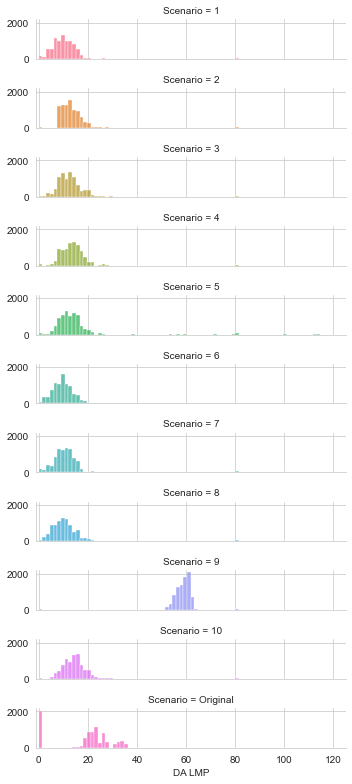

In [5]:
g = sns.FacetGrid(uncertainty_df,
                  row="Scenario",
                  hue="Scenario",
                  aspect=5,
                  height=1,
                  xlim=(-1, 125)
                 )
g.map(sns.histplot, "DA LMP", bins=5000)

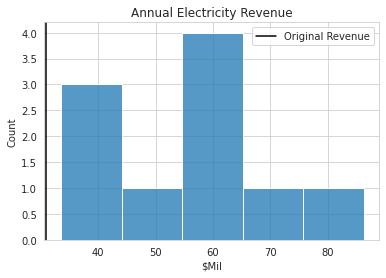

In [70]:
sns.histplot(design_df["annual_rev_E"] * 1e-6)
plt.xlabel("$Mil")
plt.title("Annual Electricity Revenue")
plt.axvline(x=rev_elec * 1e-6, label="Original Revenue", color='k')
plt.xlim((rev_elec * 1e-6 * 0.99, None))
plt.legend()

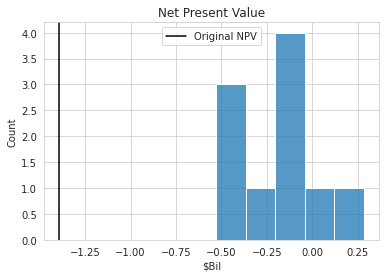

In [67]:
sns.histplot(design_df["NPV [$B]"])
plt.xlabel("$Bil")
plt.title("Net Present Value")
plt.axvline(x=NPV_bil, label="Original NPV", color='k')
plt.legend()